# Tutorial - Time Series Forecasting - Adaboost Regressor

The goal is to forecast time series with the Adaboost Regressor Approach using tsfresh for features extraction. 1) JetRail Commuter, 2) Air Passengers, 3) Function Adaboost with Air Passengers, and 5) Function Adaboost with Wine Sales.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
# !pip install tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from tqdm import tqdm

In [0]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [17]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1Y1S3y59FTzcWn77uqkYzbSKBwkadIUEy' in parents and trashed=false"}).GetList() # id of colab notes in drive 
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id'])) # chose which csv u want to download

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

title: Adaboost Regressor.ipynb, id: 1Brppd-4gLPDA_EAWcpaDuAGHo9wCDCjE
title: LSTM v3.ipynb, id: 1JD355WJ1tCmQxpklbvI0TZzvtoX-UMRG
title: VAR-Vector Autoregressif Regression Model- TS  forecasting.ipynb, id: 1JMHHsj6KGhoiIQY4zqpqEx6rjWRd6e8l
title: Untitled3.ipynb, id: 1mdw0iGEJlF52DvSOYxDlt0HB1mjuued8
title: arima_time_series.ipynb, id: 13bqq0yCE4n-bmiAwZ0H9z7Ol7fDwmrhP
title: Untitled2.ipynb, id: 1-z5pjECgQgRjAukNQOUgzidoVfTUySUf
title: Stateful LSTM v3.ipynb, id: 16k84lrJtOJWJPEw-jR1CBswDn3TBHfh1
title: Untitled1.ipynb, id: 1Jct3IwUHmyGSxW0ljTdWTPgL546H6stC
title: Untitled, id: 1d0m5GkaV2IOz3qBkDCCHoNz09XzTql7U
title: VAR-Vector Autoregressif Regression Model- TS  forecasting.ipynb, id: 1iwZ1LAFdcOmniKM6uViWxzEKZUgrSphH
title: datapreprocess.py, id: 1C6H4Xw2PZ3VCjVxQ-xXBEiAhxC7VnL7h
title: Orig_data.csv, id: 1--v137MRLlIjs_RyjycDlQEn_dpzsq_p
title: Grouped_data_unfiltered.csv, id: 1--savgur5M36coH960hsPiQ3qJOC99u_
title: Orig_data.csv, id: 1nRr7SBfAT5MpPiyi5fXNyEGtogIyqXVK
title: fi

In [18]:
file_name= drive.CreateFile({'id': '1--v137MRLlIjs_RyjycDlQEn_dpzsq_p'})
file_name.GetContentFile('Orig_data.csv')

df = pd.read_csv('Orig_data.csv') #2018-10-07 22:00:00+00:00	

df = df.drop(df.columns[0],axis = 1)



# # df['cos_Feature_hour']=np.sin(2.*np.pi*df_hours_float/24.)
# # df['sin_Feature_hour']=np.cos(2.*np.pi*df_hours_float/24.)

# #df= df.set_index('date')

# df = df.drop(["sens", "Macrosection"], axis=1)
# #df = df.replace(0,np.NaN) # np.NaN ca va marcher , np.nan doesnt work anymore !!
# df['vt_360'] = df['vt_360'].replace(0,np.NaN)
# df['qt_360'] = df['qt_360'].replace(0,np.NaN)

df = df.drop(["cos_Feature_hour" ,"sin_Feature_hour" ],axis = 1)


df.head()

,code_centrale,code_canal,date,qt_360,vt_360
0,MZE54.3,0,2015-12-31 23:00:00+00:00,15.0,98.0
1,MZE54.3,0,2016-01-01 00:00:00+00:00,11.0,105.0
2,MZE54.3,0,2016-01-01 01:00:00+00:00,24.0,110.0
3,MZE54.3,0,2016-01-01 02:00:00+00:00,51.0,109.0
4,MZE54.3,0,2016-01-01 03:00:00+00:00,31.0,106.0


In [19]:
DataFrameDict=df.groupby(['code_canal','code_centrale'])
    
#print to s
for key, item in DataFrameDict:
    print(DataFrameDict.get_group(key), "\n\n")
    #print (key)
    #DataFrameDict.get_group(key).to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\grouping_by_codes'+ str(key) +'.csv')   

    
group = [0]*len(DataFrameDict)
for i, (k, v) in enumerate(DataFrameDict):
    group[i] = DataFrameDict.get_group(k)
    
for i in range(len(group)):
      group[i] = group[i].drop(["code_centrale", "code_canal"], axis=1)

#delete  12 because has almots null data

merged = group[0]
for i in range(len(group)-1):
      merged = pd.merge(merged,group[i+1], on='date',how ='left')


merged.columns = ['date',
                  'qt_dv00', 'vt_dv00',
                  'qt_dv01', 'vt_dv01',
                  'qt_dv02', 'vt_dv02',
                  'qt_dv03', 'vt_dv03', 
                  'qt_dv04', 'vt_dv04',
                  
                  'qt_dv05', 'vt_dv05',
                  'qt_dv06', 'vt_dv06',
                  'qt_dv07', 'vt_dv07',
                  'qt_dv08', 'vt_dv08',
                  
                  'qt_dv09', 'vt_dv09',
                  'qt_dv10', 'vt_dv10', 
                  'qt_dv11', 'vt_dv11',
                  'qt_dv12', 'vt_dv12', 
                  'qt_dv13', 'vt_dv13',
                  
                  'qt_dv14', 'vt_dv14',
                  'qt_dv15', 'vt_dv15',
                  'qt_dv16', 'vt_dv16', 
                  'qt_dv17', 'vt_dv17',
                  'qt_dv18', 'vt_dv18',
                  'qt_dv19', 'vt_dv19', 
                  
                  'qt_dv20', 'vt_dv20',
                  'qt_dv21', 'vt_dv21',
                  'qt_dv22', 'vt_dv22',
                  'qt_dv23', 'vt_dv23',
                  'qt_dv24', 'vt_dv24',
                  'qt_dv25', 'vt_dv25', 
                  'qt_dv26', 'vt_dv26'
                  
#                   'cos_Feature_hour',
#                   'sin_Feature_hour'
            ]

merged.columns

      code_centrale  code_canal   ...   qt_360  vt_360
0           MZE54.3           0   ...     15.0    98.0
1           MZE54.3           0   ...     11.0   105.0
2           MZE54.3           0   ...     24.0   110.0
3           MZE54.3           0   ...     51.0   109.0
4           MZE54.3           0   ...     31.0   106.0
5           MZE54.3           0   ...     24.0   102.0
6           MZE54.3           0   ...     28.0   102.0
7           MZE54.3           0   ...      9.0   102.0
8           MZE54.3           0   ...      9.0   108.0
9           MZE54.3           0   ...     16.0   103.0
10          MZE54.3           0   ...     35.0   108.0
11          MZE54.3           0   ...     58.0   108.0
12          MZE54.3           0   ...    108.0   109.0
13          MZE54.3           0   ...     74.0   109.0
14          MZE54.3           0   ...    100.0   110.0
15          MZE54.3           0   ...    107.0   111.0
16          MZE54.3           0   ...    135.0   110.0
17        

Index(['date', 'qt_dv00', 'vt_dv00', 'qt_dv01', 'vt_dv01', 'qt_dv02',
       'vt_dv02', 'qt_dv03', 'vt_dv03', 'qt_dv04', 'vt_dv04', 'qt_dv05',
       'vt_dv05', 'qt_dv06', 'vt_dv06', 'qt_dv07', 'vt_dv07', 'qt_dv08',
       'vt_dv08', 'qt_dv09', 'vt_dv09', 'qt_dv10', 'vt_dv10', 'qt_dv11',
       'vt_dv11', 'qt_dv12', 'vt_dv12', 'qt_dv13', 'vt_dv13', 'qt_dv14',
       'vt_dv14', 'qt_dv15', 'vt_dv15', 'qt_dv16', 'vt_dv16', 'qt_dv17',
       'vt_dv17', 'qt_dv18', 'vt_dv18', 'qt_dv19', 'vt_dv19', 'qt_dv20',
       'vt_dv20', 'qt_dv21', 'vt_dv21', 'qt_dv22', 'vt_dv22', 'qt_dv23',
       'vt_dv23', 'qt_dv24', 'vt_dv24', 'qt_dv25', 'vt_dv25', 'qt_dv26',
       'vt_dv26'],
      dtype='object')

In [0]:
def get_non_null(df):
    lngth = min(list(len(col.dropna()) for ind, col in df.iteritems()))
    df = pd.concat(list(df.loc[:,col].dropna().head(lngth).reset_index(drop=True) for col in df),axis=1)
    return df

In [21]:
# take the data witn Non NaN values the data is adapted in the least number of a column
import copy 

filtered_df = get_non_null(merged)

date = copy.deepcopy(filtered_df.date) 

filtered_df = filtered_df.set_index("date")

Dataset = filtered_df

Dataset = Dataset.iloc[:5000,:]

Dataset

,qt_dv00,vt_dv00,qt_dv01,vt_dv01,qt_dv02,vt_dv02,qt_dv03,vt_dv03,qt_dv04,vt_dv04,qt_dv05,vt_dv05,qt_dv06,vt_dv06,qt_dv07,vt_dv07,qt_dv08,vt_dv08,qt_dv09,vt_dv09,qt_dv10,vt_dv10,qt_dv11,vt_dv11,qt_dv12,vt_dv12,qt_dv13,vt_dv13,qt_dv14,vt_dv14,qt_dv15,vt_dv15,qt_dv16,vt_dv16,qt_dv17,vt_dv17,qt_dv18,vt_dv18,qt_dv19,vt_dv19,qt_dv20,vt_dv20,qt_dv21,vt_dv21,qt_dv22,vt_dv22,qt_dv23,vt_dv23,qt_dv24,vt_dv24,qt_dv25,vt_dv25,qt_dv26,vt_dv26
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-31 23:00:00+00:00,15.0,98.0,10.0,82.0,14.0,91.6667,10.0,96.0000,123.0,22.3333,8.0,96.0,17.0,105.0,4.0,93.0,1.0,85.0,2.0,103.0000,6.0,104.3330,7.0,93.3333,29.0,64.33330,37.0,82.0000,2.0,64.0,1.0,94.000,3.0,97.6667,161.0,23.0000,1.0,48.0,2.0,114.000,2.0,118.0000,2.0,130.0000,135.0,93.3333,102.0,83.3333,3.0,79.3333,95.0,102.6670,112.0,105.0000
2016-01-01 00:00:00+00:00,11.0,105.0,9.0,96.0,10.0,107.6670,8.0,105.3330,142.0,86.6667,23.0,108.0,24.0,108.0,21.0,101.0,17.0,98.0,11.0,113.3330,26.0,104.6670,20.0,110.0000,26.0,65.66670,36.0,78.3333,1.0,44.0,1.0,86.000,5.0,122.6670,100.0,98.0000,3.0,44.0,3.0,115.667,3.0,121.0000,3.0,127.3330,114.0,95.3333,87.0,86.6667,11.0,95.6667,53.0,103.6670,78.0,108.0000
2016-01-01 01:00:00+00:00,24.0,110.0,24.0,102.0,27.0,102.6670,27.0,106.6670,99.0,90.0000,30.0,103.0,40.0,106.0,24.0,101.0,34.0,102.0,15.0,109.0000,25.0,108.0000,27.0,109.3330,14.0,73.33330,21.0,79.3333,1.0,54.0,1.0,108.000,2.0,111.0000,26.0,96.0000,4.0,51.0,2.0,128.000,2.0,112.0000,1.0,122.0000,71.0,98.0000,60.0,100.6670,12.0,82.6667,24.0,103.0000,30.0,104.0000
2016-01-01 02:00:00+00:00,51.0,109.0,45.0,96.0,41.0,103.6670,28.0,101.0000,57.0,86.0000,35.0,104.0,39.0,105.0,30.0,101.0,42.0,99.0,14.0,113.6670,33.0,103.0000,34.0,106.0000,12.0,75.00000,13.0,91.6667,1.0,51.0,7.0,116.000,1.0,106.0000,11.0,91.3333,11.0,52.0,1.0,114.000,2.0,106.0000,2.0,110.0000,35.0,94.6667,34.0,101.0000,16.0,88.0000,13.0,103.6670,5.0,107.3330
2016-01-01 03:00:00+00:00,31.0,106.0,27.0,99.0,29.0,103.3330,28.0,103.0000,42.0,88.0000,39.0,107.0,19.0,105.0,33.0,104.0,41.0,99.0,17.0,114.0000,33.0,107.0000,36.0,109.3330,9.0,72.00000,15.0,81.3333,2.0,40.0,2.0,108.000,2.0,108.3330,7.0,88.6667,4.0,57.0,2.0,111.000,6.0,115.6670,3.0,122.0000,31.0,87.6667,33.0,99.0000,16.0,96.0000,14.0,105.3330,6.0,118.6670
2016-01-01 04:00:00+00:00,24.0,102.0,22.0,96.0,23.0,109.6670,19.0,114.0000,41.0,83.0000,32.0,104.0,15.0,109.0,22.0,103.0,25.0,96.0,21.0,109.6670,27.0,107.0000,30.0,106.6670,8.0,57.00000,9.0,86.6667,2.0,52.0,1.0,108.000,5.0,109.3330,2.0,90.6667,2.0,52.0,5.0,99.000,3.0,118.0000,2.0,116.6670,25.0,83.3333,25.0,95.0000,9.0,94.6667,9.0,90.3333,1.0,94.0000
2016-01-01 05:00:00+00:00,28.0,102.0,19.0,92.0,26.0,100.3330,27.0,102.0000,21.0,84.3333,18.0,100.0,16.0,104.0,14.0,98.0,20.0,103.0,14.0,121.3330,20.0,98.3333,19.0,107.6670,9.0,65.66670,12.0,79.0000,1.0,61.0,4.0,111.000,23.0,122.0000,2.0,82.6667,9.0,53.0,12.0,117.667,2.0,98.0000,1.0,116.0000,16.0,91.3333,14.0,82.6667,9.0,91.3333,2.0,120.0000,2.0,104.0000
2016-01-01 06:00:00+00:00,9.0,102.0,10.0,88.0,8.0,99.0000,9.0,106.0000,18.0,83.3333,19.0,99.0,11.0,110.0,11.0,97.0,12.0,100.0,7.0,116.3330,15.0,113.6670,21.0,106.6670,6.0,70.66670,7.0,82.3333,8.0,54.0,3.0,120.000,8.0,107.6670,3.0,87.3333,3.0,52.0,1.0,114.000,1.0,166.0000,2.0,122.0000,13.0,76.0000,11.0,79.3333,6.0,99.6667,2.0,96.0000,2.0,92.6667
2016-01-01 07:00:00+00:00,9.0,108.0,13.0,86.0,8.0,108.0000,8.0,99.6667,17.0,72.6667,7.0,101.0,12.0,108.0,9.0,102.0,13.0,103.0,4.0,100.3330,15.0,112.6670,9.0,123.3330,7.0,74.00000,7.0,76.0000,4.0,58.0,10.0,107.000,11.0,117.3330,2.0,75.0000,3.0,56.0,5.0,118.000,3.0,118.0000,3.0,113.0000,7.0,72.3333,8.0,79.0000,9.0,86.0000,1.0,84.0000,2.0,54.0000


# Boosting Algorithms - Adaboost Regressor Approach with JetRail 

An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

In [22]:
# Use Forecasting frame from tsfresh for rolling forecast training
df_shift, y = make_forecasting_frame(Dataset["qt_dv00"], kind="qt_dv00", max_timeshift=20, rolling_direction=1)

df_shift

,time,value,id,kind
94791,2015-12-31 23:00:00+00:00,15.0,2016-01-01 00:00:00+00:00,qt_dv00
89793,2015-12-31 23:00:00+00:00,15.0,2016-01-01 01:00:00+00:00,qt_dv00
94792,2016-01-01 00:00:00+00:00,11.0,2016-01-01 01:00:00+00:00,qt_dv00
84796,2015-12-31 23:00:00+00:00,15.0,2016-01-01 02:00:00+00:00,qt_dv00
89794,2016-01-01 00:00:00+00:00,11.0,2016-01-01 02:00:00+00:00,qt_dv00
94793,2016-01-01 01:00:00+00:00,24.0,2016-01-01 02:00:00+00:00,qt_dv00
79800,2015-12-31 23:00:00+00:00,15.0,2016-01-01 03:00:00+00:00,qt_dv00
84797,2016-01-01 00:00:00+00:00,11.0,2016-01-01 03:00:00+00:00,qt_dv00
89795,2016-01-01 01:00:00+00:00,24.0,2016-01-01 03:00:00+00:00,qt_dv00
94794,2016-01-01 02:00:00+00:00,51.0,2016-01-01 03:00:00+00:00,qt_dv00


In [27]:
# Extracting features from df_shift
# from tsfresh import select_features
from tsfresh import extract_relevant_features


X = extract_relevant_features(df_shift,y,column_id='id', column_sort='time', column_value="value", show_warnings=False,n_jobs=6)

# X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False,n_jobs=6)
# # drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

Feature Extraction: 100%|██████████| 30/30 [05:47<00:00,  4.17s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

(4999, 288)
(4999, 288)


In [28]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]
X

variable,"value__fft_coefficient__coeff_1__attr_""real""",value__index_mass_quantile__q_0.9,value__index_mass_quantile__q_0.8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5",value__longest_strike_below_mean,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5",value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10",value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__skewness,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10",value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20","value__fft_coefficient__coeff_3__attr_""abs""",value__mean_second_derivative_central,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20","value__fft_coefficient__coeff_1__attr_""abs""",value__ar_coefficient__k_10__coeff_0,value__approximate_entropy__m_2__r_0.5,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2",value__sample_entropy,value__binned_entropy__max_bins_10,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20",value__mean_change,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""",value__quantile__q_0.3,"value__fft_coefficient__coeff_1__attr_""imag""",value__index_mass_quantile__q_0.7,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10",...,"value__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""",value__quantile__q_0.7,value__friedrich_coefficients__m_3__r_30__coeff_1,value__ratio_beyond_r_sigma__r_1.5,"value__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""",value__abs_energy,value__minimum,value__friedrich_coefficients__m_3__r_30__coeff_2,value__ratio_value_number_to_time_series_length,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__symmetry_looking__r_0.2,value__symmetry_looking__r_0.15000000000000002,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_2",value__ar_coefficient__k_10__coeff_3,value__large_standard_deviation__r_0.35000000000000003,value__friedrich_coefficients__m_3__r_30__coeff_3,"value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2",value__index_mass_quantile__q_0.1,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4",value__large_standard_deviation__r_0.30000000000000004,"value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",value__max_langevin_fixed_point__m_3__r_30,value__large_standard_deviation__r_0.25,"value__linear_trend__attr_""pvalue""","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0","value__fft_coefficient__coeff_6__attr_""abs""","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_10",value__index_mass_quantile__q_0.2,"value__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""",value__ar_coefficient__k_10__coeff_4,value__range_count__max_1000000000000.0__min_0,value__length,"value__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","value__fft_coefficient__coeff_3__attr_""real""",value__partial_autocorrelation__lag_2,value__ratio_beyond_r_sigma__r_3,"value__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","value__fft_coefficient__coeff_10__att

In [30]:
import math
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

train_size=math.floor(0.7*len(y)) #(70% Dataset)

isp = train_size   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 1500/1500 [1:09:46<00:00,  3.32s/it]


In [0]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()
train_size=math.floor(0.7*len(y))
test = ys[isp:]
train = ys[:isp]

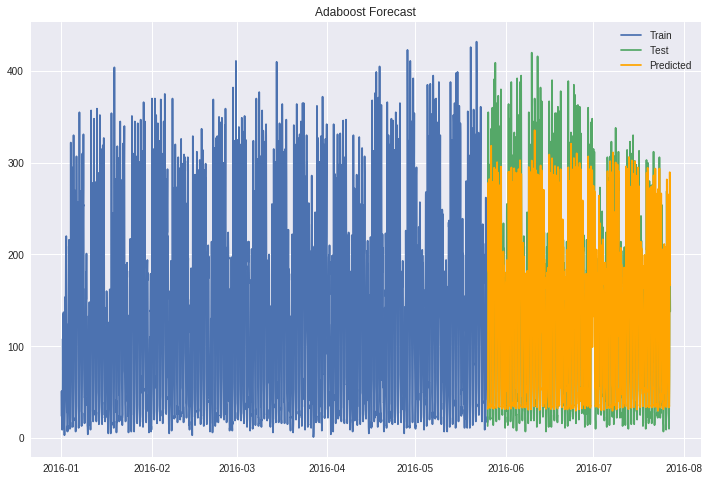

In [32]:
#Plotting data
plt.figure(figsize=(12,8))
plt.plot(train.index, train['true'], label='Train')
plt.plot(test.index, test['true'], label='Test')
plt.plot(test.index, test['pred'], label='Predicted', color = 'orange')
plt.legend(loc='best')
plt.title("Adaboost Forecast")
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("RMSE ada: ", round(sqrt(mean_squared_error(test.pred, test.true)),2))
print("MAE ada: ", round(mean_absolute_error(test.pred, test.true),2))

RMSE ada:  38.54
MAE ada:  24.53


# Importance of features

In [33]:
# Inspect the relevance of the extracted features
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
feature_last_value                                                      0.542547
value__mean_second_derivative_central                                   0.083276
value__fft_coefficient__coeff_1__attr_"abs"                             0.049023
value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"    0.037977
value__energy_ratio_by_chunks__num_segments_10__segment_focus_9         0.033629
value__energy_ratio_by_chunks__num_segments_10__segment_focus_8         0.033522
value__fft_coefficient__coeff_3__attr_"imag"                            0.026234
value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2      0.022425
value__energy_ratio_by_chunks__num_segments_10__segment_focus_3         0.018877
value__fft_coefficient__coeff_3__attr_"abs"                             0.017819
dtype: float64